In [416]:
import os

import astropy.table as at
from astropy.constants import G
import astropy.units as u
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from tqdm.notebook import tqdm
import thejoker as tj
import tables as tb

from hq.config import Config
from hq.data import get_rvdata
from hq.samples_analysis import extract_MAP_sample

from helpers import load_samples, fast_mf, fast_m2_min

from astroquery.gaia import Gaia

Gaia.login(credentials_file='/Users/apricewhelan/.gaia/archive.login')

In [2]:
c = Config.from_run_name('dr16-random')

In [324]:
allstar, allvisit = c.load_alldata()

In [7]:
meta = at.Table.read('../catalogs/lnK0.0_logL4.6_metadata_gaia_starhorse.fits')

In [21]:
meta['APOGEE_ID', 'ra', 'dec'][:3]

APOGEE_ID,ra,dec
bytes18,float64,float64
2M03002278+0028365,45.09498880429499,0.4768355362149958
2M03014113+0050064,45.4214718613846,0.8351161990584505
2M02595484+0037037,44.97851572442415,0.6176399905573305


In [26]:
Gaia.upload_table(upload_resource=meta['APOGEE_ID', 'ra', 'dec'], 
                  table_name='dr16_binaries_real')

Sending pytable.
Uploaded table 'dr16_binaries_real'.


In [97]:
q = """SELECT DISTANCE(POINT('ICRS', gaia.ra, gaia.dec), POINT('ICRS', xm.ra, xm.dec)) AS dist, 
xm.*, gaia.*
FROM user_apricewh.dr16_binaries_real as xm, gaiadr2.gaia_source as gaia
WHERE 1=CONTAINS(
  POINT('ICRS', xm.ra, xm.dec),
  CIRCLE('ICRS', gaia.ra, gaia.dec, 0.0011) 
)""" # 4 arcsec

In [98]:
job = Gaia.launch_job_async(q, name='dr16_binaries')

INFO: Query finished. [astroquery.utils.tap.core]


In [99]:
xm_tbl = job.get_results()

remove_cols = []
for col in xm_tbl.colnames:
    if xm_tbl[col].dtype == object:
        remove_cols.append(col)
xm_tbl.remove_columns(remove_cols)

xm_tbl.rename_column('apogee_id', 'APOGEE_ID')
xm_tbl['APOGEE_ID'] = xm_tbl['APOGEE_ID'].astype(str)

In [100]:
xm_tbl.write('../catalogs/dr16_binaries_gaia_xmatch.fits', overwrite=True)

In [101]:
df = xm_tbl.to_pandas()

In [102]:
grouped = df.groupby('APOGEE_ID')

In [114]:
has_nearby_stars_ids = df[df['APOGEE_ID'].groupby(df['APOGEE_ID']).transform('size') > 1]['APOGEE_ID']

In [115]:
len(meta), len(has_nearby_stars_ids)

(17682, 5645)

In [116]:
has_nearby_meta = meta[np.isin(meta['APOGEE_ID'].astype(str), has_nearby_stars_ids)]

In [117]:
reject_ids = []
for row in tqdm(has_nearby_meta):
    xm_rows = xm_tbl[xm_tbl['APOGEE_ID'] == str(row['APOGEE_ID'])]
    dG = row['phot_g_mean_mag'] - xm_rows['phot_g_mean_mag']
    check1 = np.any((xm_rows['dist']*u.deg < 2*u.arcsec) & (dG > -5) & (dG != 0))
    check2 = np.any((xm_rows['dist']*u.deg < 4*u.arcsec) & (dG > 2.5) & (dG != 0))
    
    if check1 or check2:
        reject_ids.append(row['APOGEE_ID'])

In [119]:
len(reject_ids)

601

## Find bimodal samplings:

In [316]:
from hq.samples_analysis import is_n_modal

In [350]:
bimodal_mask = np.zeros(len(meta), dtype=bool)
bimodal_modes = {}
bimodal_mode_fractions = {}
for n, row in enumerate(tqdm(meta)):
    if row['unimodal']:
        continue
        
    samples = load_samples(c, row)
    data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == row['APOGEE_ID']])
    bimodal, modes, n_per_mode = is_n_modal(data, samples, n_clusters=2)
    bimodal_mask[n] = bimodal
    
    if bimodal:
        bimodal_modes[row['APOGEE_ID']] = modes
        bimodal_mode_fractions[row['APOGEE_ID']] = np.array(n_per_mode) / sum(n_per_mode)

In [353]:
bimodal_mask.sum()

551

In [380]:
rows = []
units = dict()
for apid in tqdm(bimodal_modes.keys()):
    for samples, frac in zip(bimodal_modes[apid],
                             bimodal_mode_fractions[apid]):
        row = {'APOGEE_ID': apid}
        
        if len(samples) == 1:
            MAP_sample = samples
        else:
            MAP_idx = (samples['ln_prior'] + samples['ln_likelihood']).argmax()
            MAP_sample = samples[MAP_idx]
            
        for k in MAP_sample.par_names:
            row['MAP_' + k] = MAP_sample[k].value
            units['MAP_' + k] = MAP_sample[k].unit
        row['t0_bmjd'] = MAP_sample.t0.tcb.mjd
        row['bimodal_mode_fraction'] = frac
        
        rows.append(row)
        
tbl = at.QTable(rows)
for k in units:
    tbl[k] = tbl[k] * units[k]

In [437]:
bimodal = at.join(tbl, meta, keys='APOGEE_ID', 
                  uniq_col_name='{table_name}{col_name}', 
                  table_names=['', 'meta_'])

# recompute m2_mins
percentiles = [1, 5, 16, 50, 84, 95, 99]
for row in tqdm(bimodal):
    sample = extract_MAP_sample(row)
    mf = fast_mf(sample['P'], sample['K'], sample['e'])
    m1s = np.random.normal(row['mass'], row['mass_err'], size=1000)
    m2_mins = fast_m2_min(m1s, mf.value)
    for pp in percentiles:
        row[f'm2_min_{pp}'] = np.percentile(m2_mins, pp) * u.Msun

bimodal.write('../catalogs/bimodal.fits', overwrite=True)

---

In [279]:
llr = meta['max_unmarginalized_ln_likelihood'] - meta['robust_constant_ln_likelihood']
gold = meta[~np.isin(meta['APOGEE_ID'].astype(str), reject_ids)
            & (meta['LOGG'] > -0.5) & (meta['LOGG'] < 5.5)
            & (meta['TEFF'] > 3500) & (meta['TEFF'] < 8000)
            & (meta['M_H'] > -2.5) & (meta['M_H'] < 0.5)
            & (meta['ALPHA_M'] > -2.) & (meta['ALPHA_M'] < 2.)
            & (meta['MAP_s'] < 0.5)
            & (meta['n_visits'] > 5)
            & (llr > 25)
            # & ((meta['ASPCAPFLAG'] & 2**7) == 0)
            # & (meta['phase_coverage'] > 0.5)
            # & (meta['periods_spanned'] > 1.)
            # & (meta['max_phase_gap'] < 0.5)]
           ]
gold = gold[gold['mcmc_success']]

len(gold)

1032

In [438]:
gold.write('../catalogs/gold_sample.fits', overwrite=True)

---

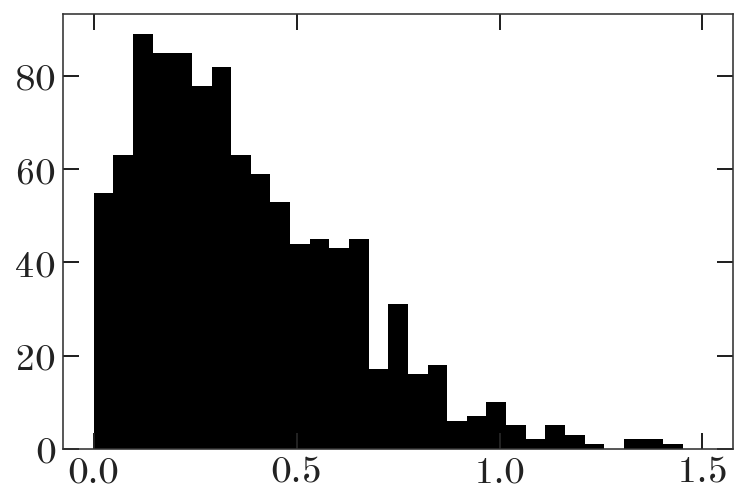

In [287]:
plt.hist(gold['m2_min_50'] / gold['mass'], 
         bins=np.linspace(0, 1., 32));

In [ ]:
sub_gold = gold[gold['LOGG'] > 3.5]

In [301]:
bin_edges = np.array([3500, 5200, 6000, 7500])
bin_ctr = 0.5 * (bin_edges[:-1] + bin_edges[1:])
bin_idx = np.digitize(sub_gold['TEFF'], bin_edges)

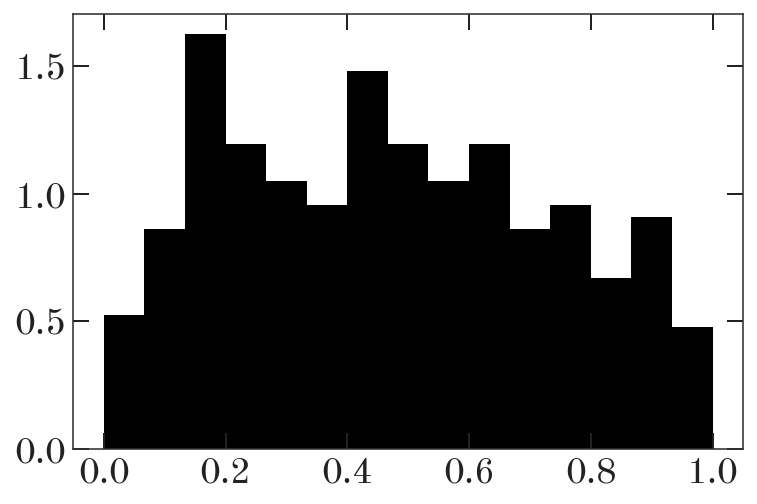

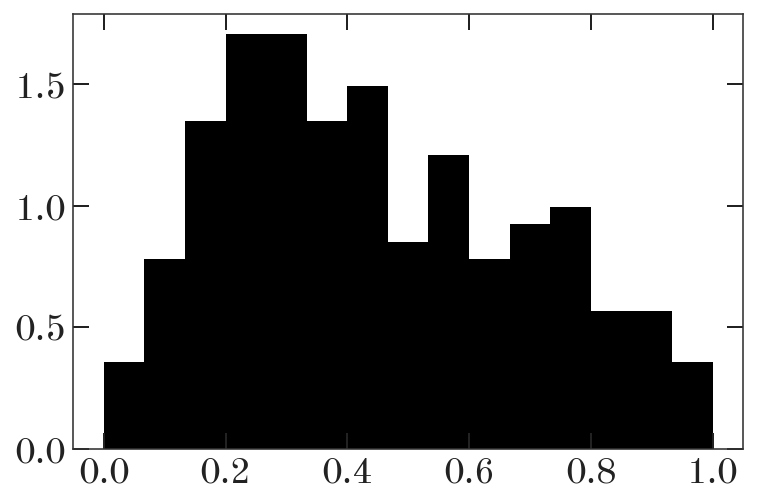

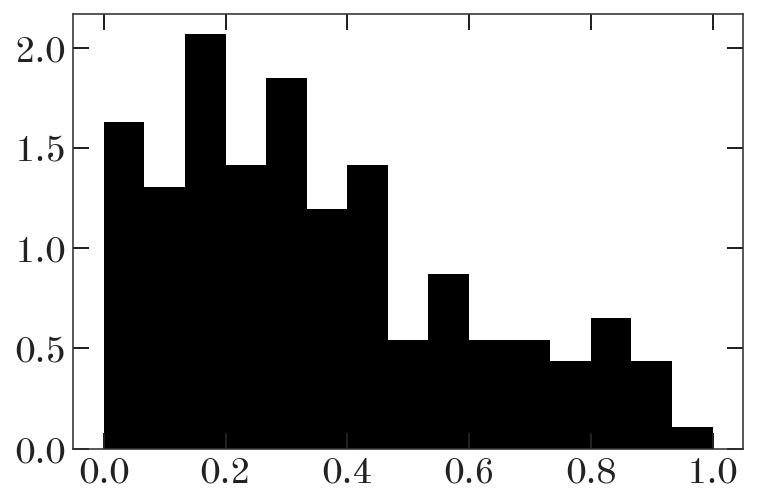

In [304]:
q_bins = np.linspace(0, 1, 16)
for i in np.arange(1, len(bin_ctr)+1):
    gold_bin = sub_gold[bin_idx == i]
    plt.figure()
    plt.hist(gold_bin['m2_min_50'] / gold_bin['mass'], 
             bins=q_bins, density=True)

In [272]:
# for row in gold[(gold['MAP_P'] < 10) & 
#                 (gold['LOGG'] > 4) & 
#                 (gold['MAP_e'] > 0.5)][:10]:
#     apid = row['APOGEE_ID']
#     with h5py.File(c.mcmc_results_path, 'r') as f:
#         samples = tj.JokerSamples.read(f[apid])
#         data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
        
#         fig, ax = plt.subplots()
#         _ = tj.plot_rv_curves(samples[:10], data=data, ax=ax)
        
#         llr = row['max_unmarginalized_ln_likelihood'] - row['robust_constant_ln_likelihood']
#         ax.set_title(f"{row['STARFLAGS']}\n{row['ASPCAPFLAGS']}\n{row['APOGEE_ID']}: {llr:.2f}", 
#                      fontsize=12)
#         print(row['APOGEE_ID'])

In [140]:
# for apid in gold[(gold['MAP_P'] < 100) & (gold['LOGG'] < 1.5)]['APOGEE_ID'][:10]:
#     with h5py.File(c.mcmc_results_path, 'r') as f:
#         samples = tj.JokerSamples.read(f[apid])
#         data = get_rvdata(allvisit[allvisit['APOGEE_ID'] == apid])
        
#         fig, ax = plt.subplots()
#         _ = tj.plot_rv_curves(samples[:10], data=data, ax=ax)